## **Healthcare Fulfillment Data Analysis**

In [4]:
#import packages needed
import warnings
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [5]:
# import data
df = pd.read_csv("take_home.csv")
df.columns

Index(['Order Created Date', 'Order Number', 'Order Status', 'Medication',
       'Dosage', 'Order Ship Date'],
      dtype='object')

In [6]:
## All status
df['Order Status'].unique()

array(['Order Complete', 'In Process', 'Awaiting Clarification',
       'Future Orders', 'Order Received', 'Unable To Fill',
       'Prescription on Hold', nan, 'Order Denied'], dtype=object)

In [7]:
# tranform dates data type for analysis
df['Order Created Date'] = pd.to_datetime( df['Order Created Date'], format = "%m/%d/%y", errors = "coerce" )
df['Order Ship Date'] = pd.to_datetime( df['Order Ship Date'], format = "%m/%d/%y", errors = "coerce" )
df['Fulfillment Time'] = (df['Order Ship Date'] - df['Order Created Date']).dt.days

In [8]:
## check time span of data
start_date = pd.to_datetime(df['Order Created Date'].min())
end_date = pd.to_datetime(df['Order Created Date'].max())
date_range = end_date - start_date

print("Date range:", start_date.date(), "to", end_date.date())
print("Total duration:", date_range.days, "days")

Date range: 2025-05-28 to 2025-06-12
Total duration: 15 days


In [9]:
# summary 
df.describe()

,Order Created Date,Order Number,Order Ship Date,Fulfillment Time
count,26863,26863.000000,25026,25026.000000
mean,2025-06-04 00:54:50.295201536,13432.000000,2025-06-06 14:56:38.897147392,2.981140
min,2025-05-28 00:00:00,1.000000,2025-05-29 00:00:00,0.000000
25%,2025-05-31 00:00:00,6716.500000,2025-06-04 00:00:00,1.000000
50%,2025-06-03 00:00:00,13432.000000,2025-06-05 00:00:00,3.000000
75%,2025-06-08 00:00:00,20147.500000,2025-06-09 00:00:00,4.000000
max,2025-06-12 00:00:00,26863.000000,2025-06-12 00:00:00,15.000000
std,NaN,7754.824477,NaN,2.015357


In [10]:
# check percentages of orders by status
order_status_counts = df['Order Status'].value_counts()
total_orders = len(df)
status_percentages = (order_status_counts / total_orders).round(5)
Order_Status_Summary = pd.DataFrame( {'Order Status Count': order_status_counts, "Percentage of Total": status_percentages })
Order_Status_Summary

,Order Status Count,Percentage of Total
Order Status,,
Order Complete,25023,0.93150
In Process,1277,0.04754
Order Received,439,0.01634
Awaiting Clarification,58,0.00216
Unable To Fill,27,0.00101
Future Orders,12,0.00045
Prescription on Hold,9,0.00034
Order Denied,1,0.00004


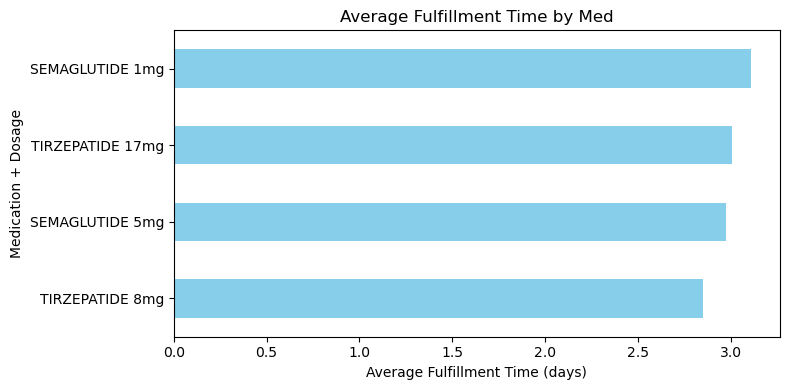

In [11]:
# visualize average fulfillment time by medication + dosage
df['Medication_Dosage'] = df['Medication'] + ' ' + df['Dosage']
avg_fulfillment_by_med = df.groupby('Medication_Dosage')['Fulfillment Time'].mean().sort_values()

top_avg_fulfillment = avg_fulfillment_by_med.sort_values(ascending=False)
plt.figure(figsize=(8, 4))
top_avg_fulfillment.plot(kind='barh', color='skyblue')
plt.xlabel('Average Fulfillment Time (days)')
plt.ylabel('Medication + Dosage')
plt.title('Average Fulfillment Time by Med')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [12]:
# check types & counts of delayed orders
Delayed_or_Unfulfilled_Orders = df[df['Order Status'].isin(['Awaiting Clarification','Prescription on Hold']) 
| df['Order Status'].isna()].groupby('Medication_Dosage').size()

Delayed_or_Unfulfilled_Orders = Delayed_or_Unfulfilled_Orders.reset_index(name='Number of Delayed')
Delayed_or_Unfulfilled_Orders = Delayed_or_Unfulfilled_Orders.sort_values('Number of Delayed', ascending=False)
Delayed_or_Unfulfilled_Orders

,Medication_Dosage,Number of Delayed
2,TIRZEPATIDE 17mg,29
1,SEMAGLUTIDE 5mg,28
0,SEMAGLUTIDE 1mg,17
3,TIRZEPATIDE 8mg,10


In [13]:
# Investigate failied orders 
unsuccessful_mask = df['Order Status'].isin(['Unable To Fill', 'Order Denied']) | df['Order Status'].isna()
total_by_dosage = df.groupby('Medication_Dosage').size()

# Failed count per dosage
failures_by_dosage = df[unsuccessful_mask].groupby('Medication_Dosage').size()
failure_rate = (failures_by_dosage / total_by_dosage * 100).fillna(0).round(2)
failure_summary = pd.DataFrame({
    'Total Orders': total_by_dosage,
    'Failed Orders': failures_by_dosage,
    'Failure Rate (%)': failure_rate
}).fillna(0).sort_values('Failure Rate (%)', ascending=False)
failure_summary

,Total Orders,Failed Orders,Failure Rate (%)
Medication_Dosage,,,
TIRZEPATIDE 17mg,9902,23,0.23
SEMAGLUTIDE 5mg,8371,13,0.16
TIRZEPATIDE 8mg,4875,6,0.12
SEMAGLUTIDE 1mg,3715,3,0.08


# **Trend Analysis**


### High Completion Rate, But Nontrivial Delays
- Out of approximately 26,863 total orders, about 25,023 were marked as “Order Complete”, indicating a strong overall throughput. However, around 1,800+ orders are in non-complete statuses
-->   This means while most orders are completed, there is a significant volume of delays or unfulfilled requests, which can impact service reliability

- Among all exception orders, higher-dosage medications consistently happen more frequently

### Average Fulfillment Time 
- The time of the data set ranges from 2025-05-28 to 2025-06-12, 15 days in total
- The average fulfillment time is 3 days, The maximum fulfillment time stretches up to 15 days
- 25% of orders are fulfilled within 1 day, 75% of orders are fulfilled within 4 days
- SEMAGLUTIDE 5mg and TIRZEPATIDE 17 mg have some of the highest average fulfillment times



# **Action Plan**
While the pharmacy demonstrates strong order completion volume, the fulfillment timeline shows significant variability, with a median of 3 days and a maximum delay of 15 days. Additionally, over 5% of orders are delayed or unresolved, which risks disrupting patient care. To ensure ultra-high service levels, the pharmacy must reduce turnaround time variability and resolve delays faster.

1. Set Fulfillment Benchmarks
- Establish a clear target: ≥95% of orders shipped within 2 business days
- Categorize medications by average fulfillment time and prioritize optimization for those exceeding the service level agreement


2. Implement Daily Exception Reporting
- Flag all orders “In Process” or “Awaiting Clarification” beyond 2 days
- Require status updates with reasons and estimated ship times for delayed orders


3. Address Bottlenecks in Compounding or Approval
- Investigate medications with the longest average fulfillment times
- Cross-train staff or adjust batching protocols to smooth peaks

4. Schedule Weekly Performance Reviews
- Review KPI trends with Mochi: average fulfillment time, % delayed, % failed
- Use this to guide staffing and process changes
